## Task - 7 [Stock Market Prediction using Numerical and Textual Analysis]

### Objective: 
Create a hybrid model for stock price/performance prediction using numerical analysis of historical stock prices, and sentimental analysis of news headlines

Here, we'll perform sentiment analysis on the given dataset using NaiveBayes Algorithm

In [20]:
# installing all the libraries.
!pip install keras
!pip install tensorflow
!pip install yfinance
!pip install yahoo-finance
!pip install yahoofinancials

  Created wheel for yahoofinancials: filename=yahoofinancials-1.6-py3-none-any.whl size=15195 sha256=83da880480c5d4ede6bfa6f92e2f3c726de1378da05d84d9567cfe1ef189cbae
  Stored in directory: c:\users\hrithvik\appdata\local\pip\cache\wheels\6a\90\0c\08c7ac2ce60b9ac91529417d471e59244f9f96848c86f14809
Successfully built yahoofinancials


In [21]:
# importing all the necessary libraries.
import warnings 
warnings.filterwarnings('ignore')


import yfinance as yf
from yahoofinancials import YahooFinancials

In [12]:
# importing all the necessary libraries before indulging in anything.

import math
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


In [13]:
# installing all the necessary libraries
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Dense, Activation

import nltk
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *

from sklearn import preprocessing, metrics
from sklearn.preprocessing import MinMaxScaler

In [23]:
# Downloading the dataset of Tesla, using yahoo libraies
tsla_df = yf.download('TSLA', 
                      start='2020-01-01', 
                      end='2021-05-15', 
                      progress=False)
tsla_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-12-31,81.000000,84.258003,80.416000,83.666000,83.666000,51428500
2020-01-02,84.900002,86.139999,84.342003,86.052002,86.052002,47660500
2020-01-03,88.099998,90.800003,87.384003,88.601997,88.601997,88892500
2020-01-06,88.094002,90.311996,88.000000,90.307999,90.307999,50665000
2020-01-07,92.279999,94.325996,90.671997,93.811996,93.811996,89410500


In [24]:
# importing the dataset from local machine

stock_price = tsla_df
stock_headlines=pd.read_csv(r'C:\Users\Hrithvik\Desktop\The Sparks Foundation\Datasets\india-news-headlines.csv')

In [25]:
stock_price.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-12-31,81.000000,84.258003,80.416000,83.666000,83.666000,51428500
2020-01-02,84.900002,86.139999,84.342003,86.052002,86.052002,47660500
2020-01-03,88.099998,90.800003,87.384003,88.601997,88.601997,88892500
2020-01-06,88.094002,90.311996,88.000000,90.307999,90.307999,50665000
2020-01-07,92.279999,94.325996,90.671997,93.811996,93.811996,89410500


In [26]:
stock_headlines.head()

,publish_date,headline_category,headline_text
0,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
1,20010102,unknown,Fissures in Hurriyat over Pak visit
2,20010102,unknown,America's unwanted heading for India?
3,20010102,unknown,For bigwigs; it is destination Goa
4,20010102,unknown,Extra buses to clear tourist traffic


In [27]:
# finding length of each dataset

len(stock_price), len(stock_headlines)

(346, 3424067)

In [29]:
stock_price.isna().any()


Open         False
High         False
Low          False
Close        False
Adj Close    False
Volume       False
dtype: bool

In [30]:
stock_headlines.isna().any()

publish_date         False
headline_category    False
headline_text        False
dtype: bool

In [34]:
stock_price = stock_price.drop_duplicates()
stock_price = stock_price.filter(['Date','Close','Open','High','Low','Volume'])
stock_price = stock_price.sort_index(ascending=True, axis=0)
stock_price

,Close,Open,High,Low,Volume
Date,,,,,
2019-12-31,83.666000,81.000000,84.258003,80.416000,51428500
2020-01-02,86.052002,84.900002,86.139999,84.342003,47660500
2020-01-03,88.601997,88.099998,90.800003,87.384003,88892500
2020-01-06,90.307999,88.094002,90.311996,88.000000,50665000
2020-01-07,93.811996,92.279999,94.325996,90.671997,89410500
...,...,...,...,...,...
2021-05-10,629.039978,664.900024,665.049988,627.609985,31392400
2021-05-11,617.200012,599.239990,627.099976,595.599976,46503900
2021-05-12,589.890015,602.489990,620.409973,586.770020,33823600


In [35]:
stock_headlines = stock_headlines.drop_duplicates()

stock_headlines['publish_date'] = stock_headlines['publish_date'].astype(str)
stock_headlines['publish_date'] = stock_headlines['publish_date'].apply(lambda x: x[0:4]+'-'+x[4:6]+'-'+x[6:8])
stock_headlines['publish_date'] = pd.to_datetime(stock_headlines['publish_date']).dt.normalize()

stock_headlines = stock_headlines.filter(['publish_date','headline_text'])

stock_headlines = stock_headlines.groupby(['publish_date'])['headline_text'].apply(lambda x: ','.join(x)).reset_index()

stock_headlines.set_index('publish_date', inplace=True)
stock_headlines = stock_headlines.sort_index(ascending=True, axis=0)
stock_headlines

,headline_text
publish_date,
2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2001-01-03,"Powerless north India gropes in the dark,Think..."
2001-01-04,The string that pulled Stephen Hawking to Indi...
2001-01-05,Light combat craft takes India into club class...
2001-01-06,Light combat craft takes India into club class...
...,...
2020-12-27,#BigInterview! Dhritiman Chatterjee: Nobody da...
2020-12-28,Horoscope Today; 28 December 2020: Check astro...
2020-12-29,Man recovers charred remains of 'thief' from h...


In [36]:
stock_data = pd.concat([stock_price,stock_headlines], axis=1)

stock_data.dropna(axis=0, inplace=True)
stock_data

,Close,Open,High,Low,Volume,headline_text
2019-12-31,83.666000,81.000000,84.258003,80.416000,51428500.0,"55 Sikhs booked for Shahidi Diwas march,Ex-stu..."
2020-01-02,86.052002,84.900002,86.139999,84.342003,47660500.0,Horoscope Today; 02 January 2020: Read predict...
2020-01-03,88.601997,88.099998,90.800003,87.384003,88892500.0,"Bank Holidays in 2020,Mazya Navryachi Bayko up..."
2020-01-06,90.307999,88.094002,90.311996,88.000000,50665000.0,With captive pics and posts; city shining on s...
2020-01-07,93.811996,92.279999,94.325996,90.671997,89410500.0,"Pro-CAA campaign in Bettiah turns unruly,Holy ..."
...,...,...,...,...,...,...
2020-12-24,661.770020,642.989990,666.090027,641.000000,22865600.0,How to set the mood for sex during cold winter...
2020-12-28,663.690002,674.510010,681.400024,660.799988,32278600.0,Horoscope Today; 28 December 2020: Check astro...
2020-12-29,665.989990,661.000000,669.900024,655.000000,22910800.0,Man recovers charred remains of 'thief' from h...
2020-12-30,694.780029,672.000000,696.599976,668.359985,42846000.0,Numerology Readings 30 December 2020: Predicti...


In [37]:
stock_data['compound']=''
stock_data['negative']=''
stock_data['neutral']=''
stock_data['positive']=''
stock_data.head()

,Close,Open,High,Low,Volume,headline_text,compound,negative,neutral,positive
2019-12-31,83.666000,81.000000,84.258003,80.416000,51428500.0,"55 Sikhs booked for Shahidi Diwas march,Ex-stu...",,,,
2020-01-02,86.052002,84.900002,86.139999,84.342003,47660500.0,Horoscope Today; 02 January 2020: Read predict...,,,,
2020-01-03,88.601997,88.099998,90.800003,87.384003,88892500.0,"Bank Holidays in 2020,Mazya Navryachi Bayko up...",,,,
2020-01-06,90.307999,88.094002,90.311996,88.000000,50665000.0,With captive pics and posts; city shining on s...,,,,
2020-01-07,93.811996,92.279999,94.325996,90.671997,89410500.0,"Pro-CAA campaign in Bettiah turns unruly,Holy ...",,,,


In [38]:
# Applying NaiveBayes logic to perform sentiment analysis on the given dataset of stocks

import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata

sid=SentimentIntensityAnalyzer()

stock_data['compound'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['compound'])
stock_data['negative'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['neg'])
stock_data['neutral'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['neu'])
stock_data['positive'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['pos'])

stock_data.head()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Hrithvik\AppData\Roaming\nltk_data...


,Close,Open,High,Low,Volume,headline_text,compound,negative,neutral,positive
2019-12-31,83.666000,81.000000,84.258003,80.416000,51428500.0,"55 Sikhs booked for Shahidi Diwas march,Ex-stu...",-0.9999,0.159,0.761,0.080
2020-01-02,86.052002,84.900002,86.139999,84.342003,47660500.0,Horoscope Today; 02 January 2020: Read predict...,-0.9997,0.125,0.796,0.079
2020-01-03,88.601997,88.099998,90.800003,87.384003,88892500.0,"Bank Holidays in 2020,Mazya Navryachi Bayko up...",-0.9963,0.103,0.805,0.092
2020-01-06,90.307999,88.094002,90.311996,88.000000,50665000.0,With captive pics and posts; city shining on s...,-0.9996,0.104,0.839,0.057
2020-01-07,93.811996,92.279999,94.325996,90.671997,89410500.0,"Pro-CAA campaign in Bettiah turns unruly,Holy ...",-1.0000,0.186,0.745,0.069


In [39]:
stock_data.drop(['headline_text'], axis = 1, inplace = True)

stock_data = stock_data[['Close','compound','negative','neutral','positive','Open','High','Low','Volume']]

stock_data.head()

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
2019-12-31,83.666000,-0.9999,0.159,0.761,0.080,81.000000,84.258003,80.416000,51428500.0
2020-01-02,86.052002,-0.9997,0.125,0.796,0.079,84.900002,86.139999,84.342003,47660500.0
2020-01-03,88.601997,-0.9963,0.103,0.805,0.092,88.099998,90.800003,87.384003,88892500.0
2020-01-06,90.307999,-0.9996,0.104,0.839,0.057,88.094002,90.311996,88.000000,50665000.0
2020-01-07,93.811996,-1.0000,0.186,0.745,0.069,92.279999,94.325996,90.671997,89410500.0


In [40]:
stock_data.to_csv('stock_data.csv')

In [41]:
stock_data=pd.read_csv('stock_data.csv',index_col=False)
stock_data.rename(columns = {'Unnamed: 0':'Date'}, inplace=True)
stock_data.set_index('Date', inplace = True)
stock_data.head()

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
Date,,,,,,,,,
2019-12-31,83.666000,-0.9999,0.159,0.761,0.080,81.000000,84.258003,80.416000,51428500.0
2020-01-02,86.052002,-0.9997,0.125,0.796,0.079,84.900002,86.139999,84.342003,47660500.0
2020-01-03,88.601997,-0.9963,0.103,0.805,0.092,88.099998,90.800003,87.384003,88892500.0
2020-01-06,90.307999,-0.9996,0.104,0.839,0.057,88.094002,90.311996,88.000000,50665000.0
2020-01-07,93.811996,-1.0000,0.186,0.745,0.069,92.279999,94.325996,90.671997,89410500.0


In [42]:
stock_data.shape

(254, 9)

In [43]:
stock_data.isna().any()

Close       False
compound    False
negative    False
neutral     False
positive    False
Open        False
High        False
Low         False
Volume      False
dtype: bool

In [44]:
stock_data.describe(include = 'all')

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
count,254.000000,254.000000,254.000000,254.000000,254.000000,254.000000,254.000000,254.000000,2.540000e+02
mean,289.184740,-0.991513,0.127587,0.794500,0.077866,288.289103,296.449709,279.909425,7.521394e+07
std,169.157447,0.125304,0.020443,0.025849,0.012376,167.842419,171.883746,163.510683,4.008567e+07
min,72.244003,-1.000000,0.076000,0.728000,0.046000,74.940002,80.972000,70.101997,1.735770e+07
25%,149.658501,-0.999900,0.113000,0.777000,0.069000,147.733501,154.663002,142.637001,4.726600e+07
50%,232.828995,-0.999700,0.127000,0.792000,0.078000,230.448006,236.333000,226.610001,6.933325e+07
75%,421.145012,-0.999500,0.140000,0.812750,0.086000,421.372513,430.349998,410.434990,9.411338e+07
max,705.669983,0.997400,0.199000,0.867000,0.127000,699.989990,718.719971,691.119995,3.046940e+08


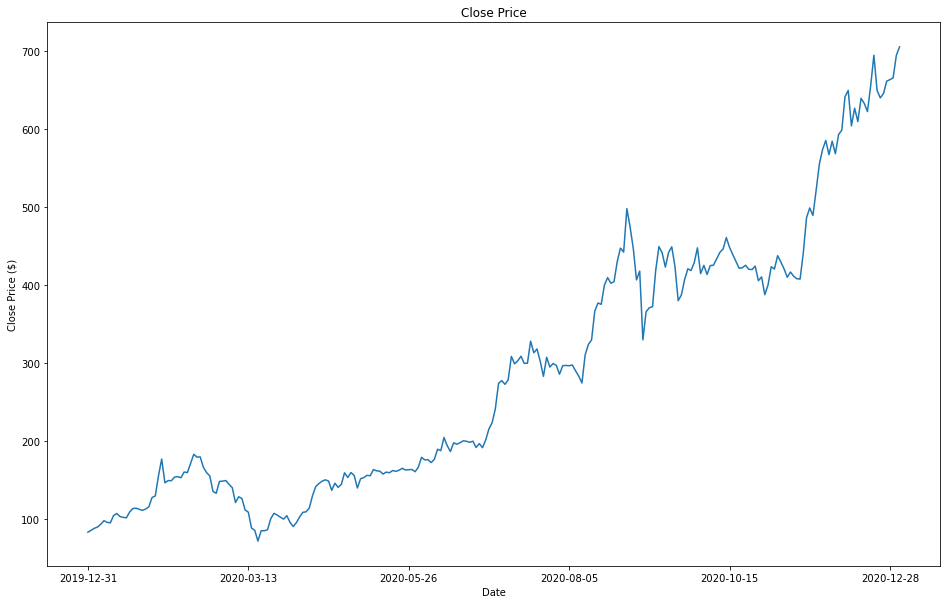

In [45]:
plt.figure(figsize = (16,10))
stock_data['Close'].plot()

plt.title('Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price ($)')
plt.show()

In [46]:
stock_data.rolling(7).mean().head(20)

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
Date,,,,,,,,,
2019-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-09,91.019428,-0.999300,0.134857,0.789857,0.075286,89.790571,92.184857,88.433429,8.942579e+07
2020-01-10,92.728570,-0.999300,0.130571,0.796000,0.073429,91.984571,94.003428,90.479715,9.133564e+07
2020-01-13,95.431427,-0.999314,0.133286,0.792857,0.073714,93.955999,96.715714,92.488000,1.034681e+08


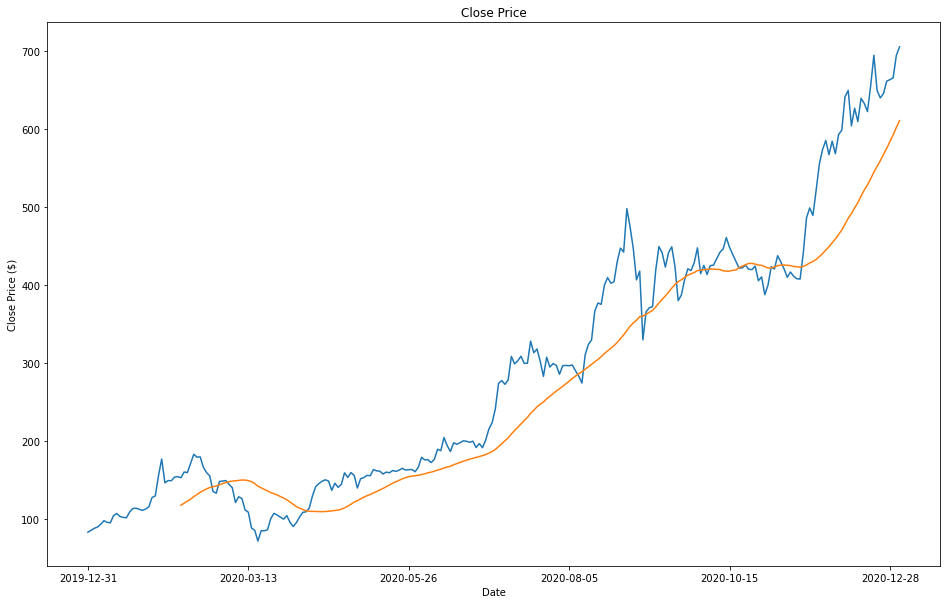

In [47]:
plt.figure(figsize = (16,10))

stock_data['Close'].plot()
stock_data.rolling(30).mean()['Close'].plot()
plt.title('Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price ($)')
plt.show()